In [1]:
import os

# List all files and directories in the root of the Kaggle environment
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/wm811k-wafer-map/LSWMD.pkl


In [130]:
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import KFold, cross_val_score,train_test_split

import matplotlib.pyplot as plt

datapath = join('/kaggle/input/wm811k-wafer-map/LSWMD.pkl')
print(datapath)

/kaggle/input/wm811k-wafer-map/LSWMD.pkl


In [131]:
df = pd.read_pickle(datapath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [132]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [133]:
df = df.drop(['waferIndex'], axis = 1)
df.drop(columns=['dieSize', 'lotName'], inplace=True)
df = df[df['failureType'].apply(lambda x: bool(x) and bool(x[0]))]

df

,waferMap,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]]
...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",[[Test]],[[Edge-Loc]]
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",[[Test]],[[Edge-Loc]]
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",[[Test]],[[Edge-Loc]]


In [134]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df

,waferMap,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)"
...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",[[Test]],[[Edge-Loc]],"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",[[Test]],[[Edge-Loc]],"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",[[Test]],[[Edge-Ring]],"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",[[Test]],[[Edge-Loc]],"(26, 30)"


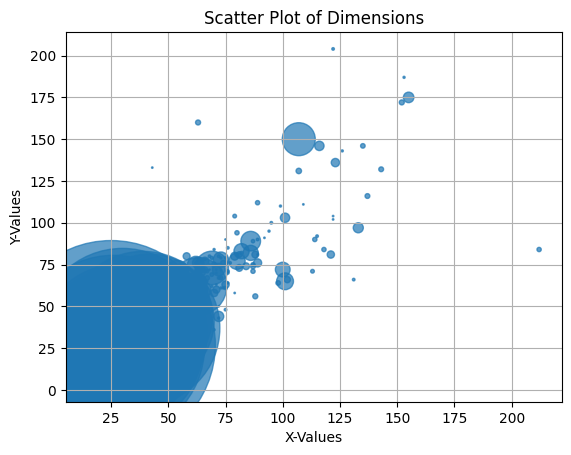

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the X and Y values from the Dimension column (assuming it's the last column in your dataset)
df[['X-Values', 'Y-Values']] = pd.DataFrame(df['waferMapDim'].tolist(), index=df.index)

# Group by X-Values and Y-Values, and count occurrences
grouped_df = df.groupby(['X-Values', 'Y-Values']).size().reset_index(name='Count')

# Create the scatter plot
plt.scatter(grouped_df['X-Values'], grouped_df['Y-Values'], s=grouped_df['Count']*1.2, alpha=0.7)  
plt.xlabel('X-Values')
plt.ylabel('Y-Values')
plt.title('Scatter Plot of Dimensions')
plt.grid(True)
plt.show()

In [136]:
grouped_df

,X-Values,Y-Values,Count
0,15,3,1
1,18,4,1
2,18,44,1
3,22,35,2
4,22,50,899
...,...,...,...
341,143,132,10
342,152,172,11
343,153,187,2
344,155,175,48


In [137]:
# Save the new DataFrame to an Excel file
output_file = 'scatter_plot_data.xlsx'
grouped_df.to_excel(output_file, index=False)
print(f"The new DataFrame has been saved as '{output_file}'.")

The new DataFrame has been saved as 'scatter_plot_data.xlsx'.


In [138]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df

,waferMap,trianTestLabel,failureType,waferMapDim,X-Values,Y-Values,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)",45,48,8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)",45,48,8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)",45,48,8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)",45,48,8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[none]],"(45, 48)",45,48,8,0
...,...,...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",[[Test]],[[Edge-Loc]],"(26, 30)",26,30,2,1
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",[[Test]],[[Edge-Loc]],"(26, 30)",26,30,2,1
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",[[Test]],[[Edge-Ring]],"(26, 30)",26,30,3,1
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",[[Test]],[[Edge-Loc]],"(26, 30)",26,30,2,1


In [139]:
df['failureType'].value_counts()

failureType
[[none]]         147431
[[Edge-Ring]]      9680
[[Edge-Loc]]       5189
[[Center]]         4294
[[Loc]]            3593
[[Scratch]]        1193
[[Random]]          866
[[Donut]]           555
[[Near-full]]       149
Name: count, dtype: int64

In [140]:
import pandas as pd

# Filter rows for `none` class and other classes
none_class = df[df['failureType'] == 'none']
other_classes = df[df['failureType'] != 'none']

# Keep only the first 15,000 rows of the `none` class
none_class_limited = none_class.head(15000)

# Combine the limited `none` class rows with other classes
filtered_df = pd.concat([none_class_limited, other_classes], ignore_index=True)

# Shuffle the DataFrame
filtered_df = filtered_df.sample(frac=1).reset_index(drop=True)

# Display the result
filtered_df


,waferMap,trianTestLabel,failureType,waferMapDim,X-Values,Y-Values,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",[[Training]],[[Center]],"(25, 27)",25,27,0,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[Edge-Ring]],"(46, 46)",46,46,3,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[Edge-Loc]],"(42, 61)",42,61,2,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,...",[[Test]],[[none]],"(26, 26)",26,26,8,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",[[Training]],[[Loc]],"(35, 31)",35,31,4,0
...,...,...,...,...,...,...,...,...
40514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2,...",[[Training]],[[none]],"(26, 26)",26,26,8,0
40515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",[[Test]],[[none]],"(26, 26)",26,26,8,1
40516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",[[Training]],[[Edge-Ring]],"(38, 36)",38,36,3,0
40517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1,...",[[Test]],[[none]],"(26, 26)",26,26,8,1


In [141]:
filtered_df['failureType'].value_counts()

failureType
[[none]]         15000
[[Edge-Ring]]     9680
[[Edge-Loc]]      5189
[[Center]]        4294
[[Loc]]           3593
[[Scratch]]       1193
[[Random]]         866
[[Donut]]          555
[[Near-full]]      149
Name: count, dtype: int64

In [142]:
filtered_df

,waferMap,trianTestLabel,failureType,waferMapDim,X-Values,Y-Values,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2,...",[[Training]],[[Center]],"(25, 27)",25,27,0,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[Edge-Ring]],"(46, 46)",46,46,3,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",[[Training]],[[Edge-Loc]],"(42, 61)",42,61,2,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2,...",[[Test]],[[none]],"(26, 26)",26,26,8,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",[[Training]],[[Loc]],"(35, 31)",35,31,4,0
...,...,...,...,...,...,...,...,...
40514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2,...",[[Training]],[[none]],"(26, 26)",26,26,8,0
40515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",[[Test]],[[none]],"(26, 26)",26,26,8,1
40516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",[[Training]],[[Edge-Ring]],"(38, 36)",38,36,3,0
40517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1,...",[[Test]],[[none]],"(26, 26)",26,26,8,1


In [143]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap using hex values
colors = ['#FFFFFF', '#018ABD', '#004581']  
n_bins = 3  # Number of bins (0, 1, 2)
cmap_name = 'custom_cmap'

# Create the colormap from hex values
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

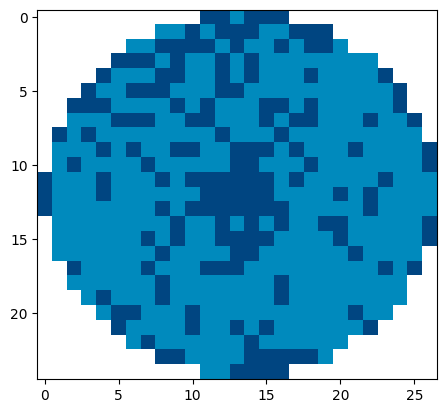

Faulty case : [['Center']] 


In [144]:
# plot 1st data
plt.imshow(filtered_df['waferMap'][0], cmap=cm)
plt.show()

# check faulty case
print('Faulty case : {} '.format(filtered_df['failureType'][0]))

In [145]:
import numpy as np
import cv2 

# Resize all wafer maps in the DataFrame to (32, 32)
filtered_df['waferMap'] = filtered_df['waferMap'].apply(lambda x: cv2.resize(np.array(x), (32, 32), interpolation=cv2.INTER_LINEAR))
filtered_df['waferMapDim']=filtered_df.waferMap.apply(find_dim)

filtered_df = filtered_df.reset_index(drop=True)

filtered_df

,waferMap,trianTestLabel,failureType,waferMapDim,X-Values,Y-Values,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,...",[[Training]],[[Center]],"(32, 32)",25,27,0,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",[[Training]],[[Edge-Ring]],"(32, 32)",46,46,3,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",[[Training]],[[Edge-Loc]],"(32, 32)",42,61,2,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",[[Test]],[[none]],"(32, 32)",26,26,8,1
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",[[Training]],[[Loc]],"(32, 32)",35,31,4,0
...,...,...,...,...,...,...,...,...
40514,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",[[Training]],[[none]],"(32, 32)",26,26,8,0
40515,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",[[Test]],[[none]],"(32, 32)",26,26,8,1
40516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2,...",[[Training]],[[Edge-Ring]],"(32, 32)",38,36,3,0
40517,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",[[Test]],[[none]],"(32, 32)",26,26,8,1


In [146]:
# Convert wafer maps to a single NumPy array (batch, 32, 32)
sw = np.stack(filtered_df['waferMap'])

# Extract failureType and flatten the first character of the labels
label = filtered_df['failureType'].tolist()

In [147]:
x = sw[1:]
y = np.array(label[1:]).reshape((-1,1))

In [148]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (40518, 32, 32), y shape : (40518, 1)


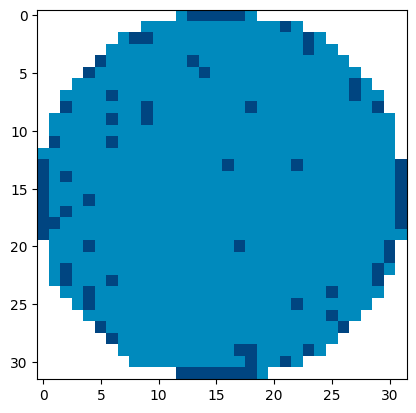

Faulty case : ['Edge-Ring'] 


In [149]:
# plot 1st data
plt.imshow(x[0], cmap=cm)
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [150]:
x = x.reshape((-1, 32, 32, 1))

In [ ]:
faulty_cases = np.unique(y)
print('Faulty case list : {}'.format(faulty_cases))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [152]:
for case in faulty_cases :
    print('{} : {}'.format(case, len(y[y==case])))

Center : 4293
Donut : 555
Edge-Loc : 5189
Edge-Ring : 9680
Loc : 3593
Near-full : 149
Random : 866
Scratch : 1193
none : 15000


In [153]:
new_x = np.zeros((len(x), 32, 32, 3))

for w in range(len(x)):
    for i in range(32):
        for j in range(32):
            new_x[w, i, j, int(x[w, i, j])] = 1
    if w%10000==0:
        print(w/10000,'*10k done!')

0.0 *10k done!
1.0 *10k done!
2.0 *10k done!
3.0 *10k done!
4.0 *10k done!


In [154]:
new_x.shape

(40518, 32, 32, 3)

In [155]:
y.shape

(40518, 1)

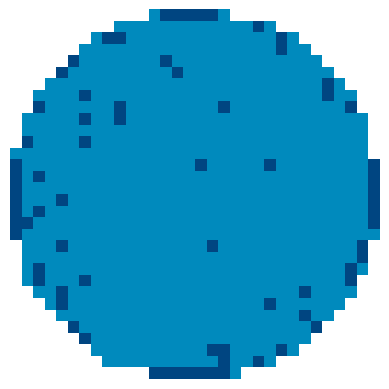

In [156]:
# Check original faulty wafer data
plt.imshow(np.argmax(new_x[0], axis=2), cmap=cm)

plt.axis('off')
plt.show()


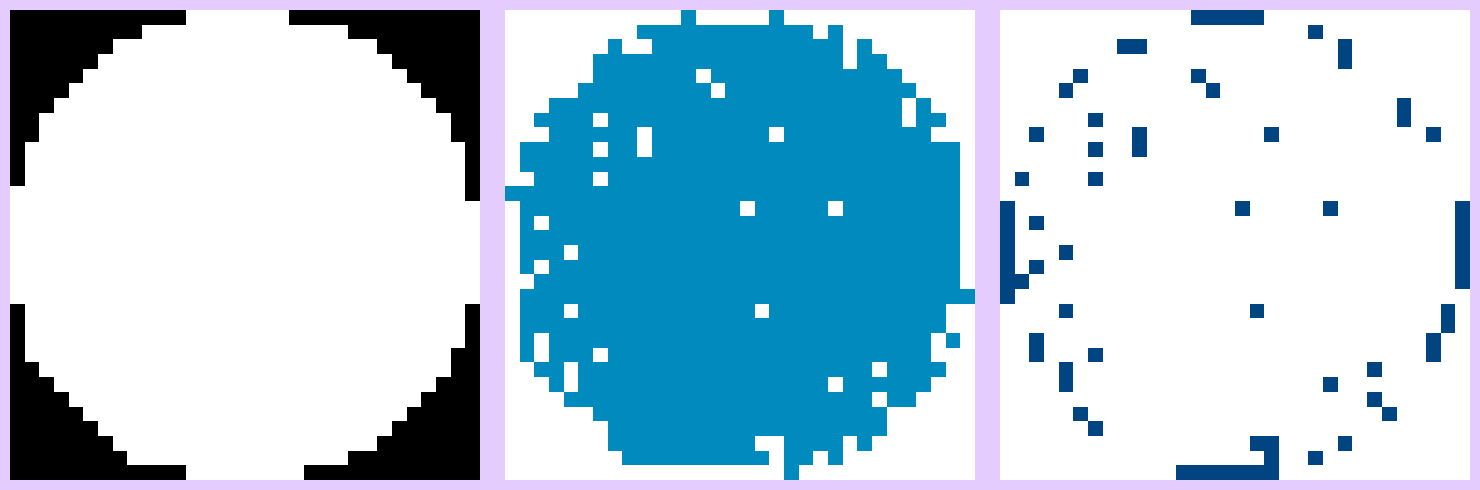

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define custom colormaps for each channel
cmap2 = LinearSegmentedColormap.from_list("blue", ['#FFFFFF', '#018ABD'], N=2)  
cmap3 = LinearSegmentedColormap.from_list("deep_blue", ['#FFFFFF', '#004581'], N=2)  

# Sample index for visualization
idx = 0 

# Extract the wafer map for the selected sample
sample = new_x[idx]

# Plotting the three channels separately
plt.figure(figsize=(15, 5))
plt.gcf().set_facecolor('#E5CCFF')


for channel in range(3): 
    plt.subplot(1, 3, channel + 1)
    if channel==0:
        plt.imshow(sample[:, :, channel], cmap='gray_r') 
    if channel==1:
        plt.imshow(sample[:, :, channel], cmap=cmap2) 
    if channel==2:
        plt.imshow(sample[:, :, channel], cmap=cmap3)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Filter the DataFrame to only include rows where 'trianTestLabel' contains 'Test'
test_df = filtered_df[filtered_df['trianTestLabel'].apply(lambda x: 'Test' in x)]

# Reset the index of the DataFrame
test_df = test_df.reset_index(drop=True)

# Filter the test dataset to include only valid rows
test_df_filtered = test_df[
    (test_df['waferMap'].apply(lambda wm: isinstance(wm, (np.ndarray, list)))) & 
    (test_df['failureType'] != 'none') 
]

test_df_filtered

,waferMap,trianTestLabel,failureType,waferMapDim,X-Values,Y-Values,failureNum,trainTestNum
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",[[Test]],[[Edge-Loc]],"(32, 32)",45,42,2,1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",[[Test]],[[Loc]],"(32, 32)",44,41,4,1
6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",[[Test]],[[Loc]],"(32, 32)",26,26,4,1
7,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",[[Test]],[[Edge-Loc]],"(32, 32)",41,40,2,1
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",[[Test]],[[Edge-Loc]],"(32, 32)",44,41,2,1
...,...,...,...,...,...,...,...,...
11755,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",[[Test]],[[Loc]],"(32, 32)",39,37,4,1
11756,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",[[Test]],[[Loc]],"(32, 32)",34,34,4,1
11757,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",[[Test]],[[Scratch]],"(32, 32)",44,43,6,1
11758,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",[[Test]],[[Center]],"(32, 32)",41,45,0,1


In [159]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Extract and normalize wafer maps
images = np.array(filtered_df['waferMap'].tolist()).astype('float32') / 2.0  # Normalize to [0, 1]
images = np.expand_dims(images, axis=-1)  # (N, 32, 32, 1)

# One-hot encode the labels
labels = to_categorical(filtered_df['failureNum'], num_classes=9)

print(f"Training data shape: {images.shape}, Labels shape: {labels.shape}")

Training data shape: (40519, 32, 32, 1), Labels shape: (40519, 9)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Lambda,
                                     Concatenate, Conv2D, Conv2DTranspose, Layer)
from tensorflow.keras.utils import to_categorical

# === Sampling Layer ===
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# === Config ===
input_shape = (32, 32, 1)
label_shape = (9,)
latent_dim = 64
layer_filters = [16, 32]
kernel_size = 3

# === Encoder ===
x_input = Input(shape=input_shape, name='image_input')
y_input = Input(shape=label_shape, name='label_input')

y_embed = Dense(32 * 32, activation='relu')(y_input)
y_embed = Reshape((32, 32, 1))(y_embed)
x = Concatenate()([x_input, y_embed])

for f in layer_filters:
    x = Conv2D(f, kernel_size, strides=2, activation='relu', padding='same')(x)

conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])

encoder = Model([x_input, y_input], [z_mean, z_log_var, z], name='encoder')
# encoder.summary()

# === Decoder ===
z_input = Input(shape=(latent_dim,))
y_input_dec = Input(shape=label_shape)

d = Concatenate()([z_input, y_input_dec])
d = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d)
d = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(d)

for f in reversed(layer_filters):
    d = Conv2DTranspose(f, kernel_size, strides=2, activation='relu', padding='same')(d)

decoder_output = Conv2DTranspose(1, kernel_size, activation='sigmoid', padding='same')(d)
decoder = Model([z_input, y_input_dec], decoder_output, name='decoder')
# decoder.summary()

# === Custom Loss Layer ===
class LossLayer(Layer):
    def call(self, inputs):
        x_true, x_pred, z_mean, z_log_var = inputs

        # shape: (batch, 32, 32) — no channel dim
        bce = tf.keras.losses.binary_crossentropy(x_true, x_pred)

        # Reduce over height and width (axis 1, 2)
        recon = tf.reduce_sum(bce, axis=[1, 2])

        # KL divergence (standard)
        kl = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)

        # Add total loss to model
        self.add_loss(tf.reduce_mean(recon + kl))
        return x_pred


# === CVAE ===
z_mean, z_log_var, z = encoder([x_input, y_input])
x_recon = decoder([z, y_input])

x_output = LossLayer()([x_input, x_recon, z_mean, z_log_var])
cvae = Model([x_input, y_input], x_output, name='CVAE')
cvae.compile(optimizer='adam')

cvae.summary()

# === Train ===
cvae.fit([images, labels], images,
         epochs=20,
         batch_size=64)

Model: "CVAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label_input (InputLayer)  │ (None, 9)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 64), (None,    │         50,144 │ image_input[0][0],     │
│                           │ 64), (None, 64)]       │                │ label_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 32, 32, 1)      │        165,569 │ encoder[0][2],         │
│                           │                        │                │ label_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ loss_layer_4 (LossLayer)  │ (None, 32, 32, 1)      │              0 │ image_input[0][0],     │
│                           │                        │                │ decoder[0][0],         │
│                           │                        │                │ encoder[0][0],         │
│                           │                        │                │ encoder[0][1]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 215,713 (842.63 KB)

 Trainable params: 215,713 (842.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 604.2774
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 564.1412
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 561.4113
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 560.1874
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 560.0797
Epoch 6/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 559.3898
Epoch 7/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 559.1384
Epoch 8/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 559.2410
Epoch 9/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 559.0414
Epoch 10/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 558.9965
Epoch 11/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 559.0044
Epoch 12/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 558.3530
Epoch 13/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 558.1415
Epoch 14/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 557.5358
Epoch 15/20
634/634 ━━━━━━━━

In [161]:
from tensorflow.keras.optimizers import Adam

# Encoder
input_shape = (32, 32, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))

# Compile the model
ae.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',           
)

In [162]:
# start train
ae.fit(new_x, new_x,
       batch_size=64,
       epochs=30,
       validation_split=0.2,
       verbose=1)

Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0456 - val_loss: 0.0051
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0010 - val_loss: 7.6364e-04
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 6.8525e-04 - val_loss: 5.8476e-04
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.2240e-04 - val_loss: 4.4902e-04
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.1273e-04 - val_loss: 3.6745e-04
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.5114e-04 - val_loss: 3.3783e-04
Epoch 9/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8639e-04 - val_loss: 2.7860e-04
Epoch 10/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4446e-04 - val_loss: 2.3941e-04
Epoch 11/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2522e-04 - val_loss: 2.5

In [163]:
encoder = models.Model(input_tensor, latent_vector)

In [164]:
decoder_input = Input((16, 16, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [165]:
# Encode original faulty wafer
latent = encoder.predict(new_x)

# Add noise to encoded latent faulty wafers vector.
noised_latent = latent + np.random.normal(loc=0, scale=0.1, size = (len(latent), 16, 16, 64))

noised_gen_x = np.argmax(decoder.predict(noised_latent), axis=3)

1267/1267 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


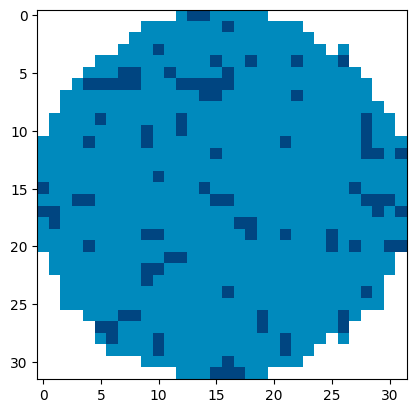

In [95]:
# check new noised faulty wafer data
plt.imshow(noised_gen_x[9], cmap=cm)

In [167]:
new_x.shape, y.shape

((40518, 32, 32, 3), (40518, 1))

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    noised_latent = encoder.predict(wafer)

    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 32, 32, 3))

    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        latent = noised_latent + np.random.normal(loc=0, scale=0.1, size = (len(noised_latent), 16, 16, 64))
        noised_gen_x = decoder.predict(latent)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    
    gen_y = np.full((len(gen_x), 1), label)

    return gen_x[1:], gen_y[1:]

In [169]:
# Augmentation for all faulty case.
for case in faulty_cases :
    # skip none case
    if case == 'none' :
        continue

    gen_x, gen_y = gen_data(new_x[np.where(y==case)[0]], case)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━

In [170]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (72563, 32, 32, 3), new_y shape : (72563, 1)


In [171]:
for case in faulty_cases :
    print('{} : {}'.format(case, len(y[y==case])))

Center : 8586
Donut : 2775
Edge-Loc : 10378
Edge-Ring : 19360
Loc : 7186
Near-full : 2235
Random : 3464
Scratch : 3579
none : 15000


In [172]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=len(y[y == 'none']), replace=False)]

In [173]:
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [174]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (57563, 32, 32, 3), new_y shape : (57563, 1)


In [ ]:
for case in faulty_cases :
    print('{} : {}'.format(case, len(new_y[new_y==case])))

Center : 8586
Donut : 2775
Edge-Loc : 10378
Edge-Ring : 19360
Loc : 7186
Near-full : 2235
Random : 3464
Scratch : 3579
none : 0


In [ ]:
faulty_cases

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype='<U9')

In [ ]:
for i, l in enumerate(faulty_cases):
    new_y[new_y==l] = i

# one-hot-encoding
new_y = to_categorical(new_y)

In [180]:
print(new_y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [181]:
unique_rows = np.unique(new_y, axis=0)

print("Unique rows:")
print(unique_rows)


Unique rows:
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [182]:
unique_rows, counts = np.unique(new_y, axis=0, return_counts=True)

# Display the unique rows and their counts
for row, count in zip(unique_rows, counts):
    print(f"Row: {row}, Count: {count}")


Row: [0. 0. 0. 0. 0. 0. 0. 1.], Count: 3579
Row: [0. 0. 0. 0. 0. 0. 1. 0.], Count: 3464
Row: [0. 0. 0. 0. 0. 1. 0. 0.], Count: 2235
Row: [0. 0. 0. 0. 1. 0. 0. 0.], Count: 7186
Row: [0. 0. 0. 1. 0. 0. 0. 0.], Count: 19360
Row: [0. 0. 1. 0. 0. 0. 0. 0.], Count: 10378
Row: [0. 1. 0. 0. 0. 0. 0. 0.], Count: 2775
Row: [1. 0. 0. 0. 0. 0. 0. 0.], Count: 8586


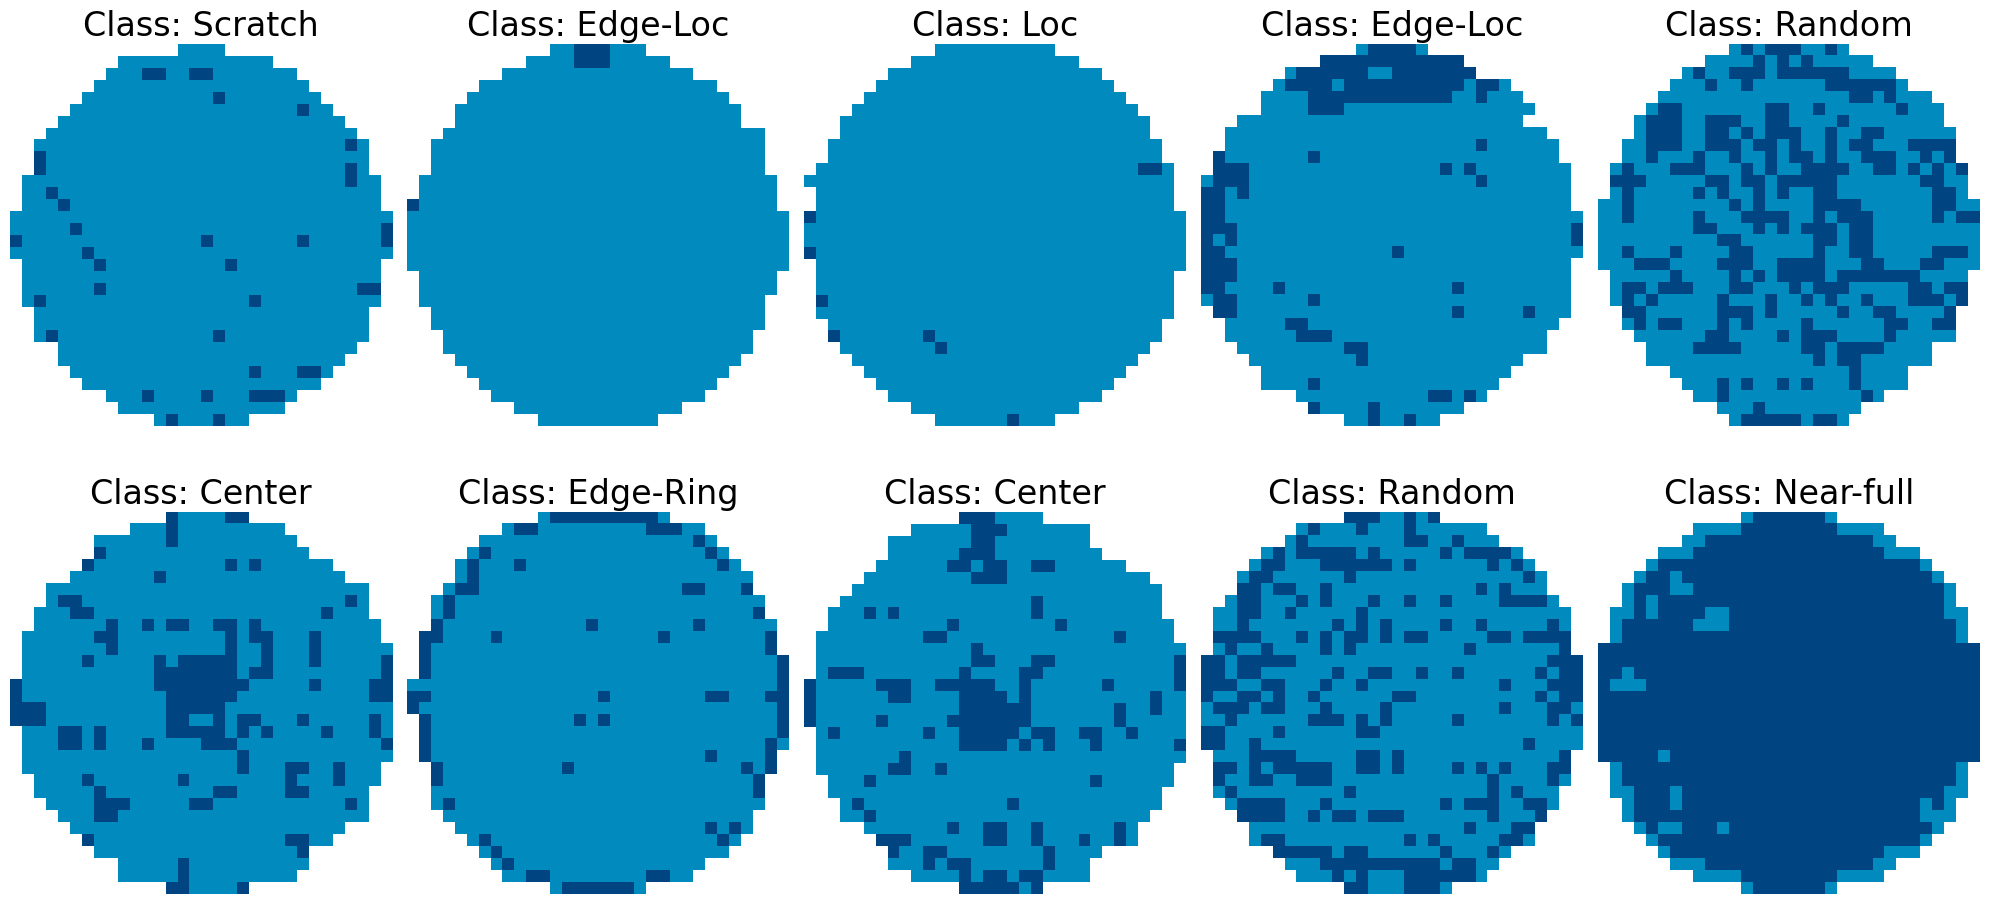

In [ ]:
# Randomly select 10 indices
random_indices = np.random.choice(len(new_x), size=10, replace=False)

# Plotting
plt.figure(figsize=(20, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    wafer_map = new_x[idx]  # Get the wafer map
    class_index = np.argmax(new_y[idx])  # Get the class index
    class_name = faulty_cases[class_index]  # Get the class name using the index
    plt.imshow(np.argmax(wafer_map, axis=-1), cmap=cm)  # Display the wafer map
    plt.title(f"Class: {class_name}", fontsize=24) 
    plt.axis('off')

plt.tight_layout()
plt.show()


In [184]:
from sklearn.model_selection import KFold, cross_val_score,train_test_split
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.15,
                                                    shuffle=True)

In [185]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (48928, 32, 32, 3), y : (48928, 8)
Test x: (8635, 32, 32, 3), y : (8635, 8)


In [ ]:
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split

# Define the Differential Attention Layer
class DifferentialAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, lambda_init=0.8):
        super(DifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."

        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.lambda_param = tf.Variable(lambda_init, trainable=True, dtype=tf.float32)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, projection_dim)."""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch, num_heads, seq_len, projection_dim)

    def compute_attention(self, query, key, value):
        """Compute scaled dot-product attention."""
        matmul_qk = tf.matmul(query, key, transpose_b=True)  # (batch, num_heads, seq_len, seq_len)
        d_k = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.sqrt(d_k)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (batch, num_heads, seq_len, seq_len)
        return tf.matmul(attention_weights, value)  # (batch, num_heads, seq_len, projection_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Linear projections for Q, K, V
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split Q into Q1 and Q2, and K into K1 and K2
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        q1, q2 = tf.split(query, num_or_size_splits=2, axis=-1)  # Split last dim into two
        k1, k2 = tf.split(key, num_or_size_splits=2, axis=-1)

        # Compute differential attention
        attn1 = self.compute_attention(q1, k1, value)
        attn2 = self.compute_attention(q2, k2, value)

        diff_attn = attn1 - self.lambda_param * attn2

        # Concatenate attention heads and project
        diff_attn = tf.transpose(diff_attn, perm=[0, 2, 1, 3])  # (batch, seq_len, num_heads, projection_dim)
        concat_diff_attn = tf.reshape(diff_attn, (batch_size, -1, self.embed_dim))  # (batch, seq_len, embed_dim)

        return concat_diff_attn


# Input layer
input_layer = Input(shape=(32, 32, 3), name="Input_Layer")

# Convolutional and Pooling layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv1")(input_layer)
x = layers.BatchNormalization(name="BatchNorm1")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool1")(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv2")(x)
x = layers.BatchNormalization(name="BatchNorm2")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool2")(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv3")(x)
x = layers.BatchNormalization(name="BatchNorm3")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool3")(x)

# Differential Attention Layer
x = DifferentialAttention(embed_dim=64, num_heads=16, lambda_init=0.8)(x)
x._name = 'diffAtten'
x = layers.GlobalAveragePooling1D()(x)

# Flatten layer
x = layers.Flatten(name="Flatten")(x)

# Fully connected layers
x = layers.Dropout(0.3, name="Dropout1")(x)
x = layers.Dense(32, activation='relu', name="Dense_128")(x)
x = layers.Dropout(0.2, name="Dropout2")(x)

# Output layer
output_layer = layers.Dense(8, activation='softmax', name="Output_Layer")(x)

# Define the model
model = models.Model(inputs=input_layer, outputs=output_layer, name="Functional_Model")

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "Functional_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm1 (BatchNormalization)      │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool1 (MaxPooling2D)              │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm2 (BatchNormalization)      │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool2 (MaxPooling2D)              │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm3 (BatchNormalization)      │ (None, 8, 8, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool3 (MaxPooling2D)              │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ differential_attention               │ (None, None, 64)            │          24,768 │
│ (DifferentialAttention)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,256 (473.66 KB)

 Trainable params: 120,808 (471.91 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    # Stop training early if validation loss stops improving
    EarlyStopping(
        monitor='val_accuracy', 
        patience=10,  
        restore_best_weights=True, 
        verbose=1
    ),
    # Save the best model based on validation loss
    ModelCheckpoint(
        filepath='/kaggle/working/best_model.keras', 
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5,  
        patience=10, 
        min_lr=1e-6, 
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    shuffle=True,
    verbose=1,
    callbacks=callbacks 
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
1221/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.0099
Epoch 1: val_accuracy improved from -inf to 0.98150, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9969 - loss: 0.0099 - val_accuracy: 0.9815 - val_loss: 0.1175 - learning_rate: 2.5000e-04
Epoch 2/50
1217/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0082
Epoch 2: val_accuracy improved from 0.98150 to 0.98161, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9816 - val_loss: 0.1330 - learning_rate: 2.5000e-04
Epoch 3/50
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0079
Epoch 3: val_accuracy did not improve from 0.98161
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9805 - val_loss: 0.1382 - learning_rate: 2.5000e-04
Epoch 4/50
1224/1224 ━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize empty lists for features and labels
test_X = []
test_Y = []

# Loop through the filtered test dataframe to reshape and collect data
for i, row in test_df_filtered.iterrows():
    try:
        # Process the waferMap, ensuring it's a valid 2D array (32, 32)
        wafer_map = np.array(row['waferMap']).reshape(32, 32)
        test_X.append(wafer_map)

        # Append the first failure type as the label
        if len(row['failureType']) > 0:
            test_Y.append(row['failureType'][0])
    except Exception as e:
        print(f"Error processing row {i}: {e}")

# Convert the list of wafer maps and labels into numpy arrays
test_X = np.array(test_X)

# One-hot encode the labels
label_encoder = LabelEncoder()
test_Y_encoded = label_encoder.fit_transform(test_Y)
test_Y = to_categorical(test_Y_encoded, num_classes=8)

# Ensure the shape of the test_X is correct (32, 32, 1)
test_X = test_X.reshape(-1, 32, 32, 1)

print("Shape of test_X_encoded:", test_X.shape)
print("Shape of test_Y:", test_Y.shape)

Shape of test_X_encoded: (7894, 32, 32, 1)
Shape of test_Y: (7894, 8)


In [ ]:
# One-hot encode the test_X (same as preprocessing for training data)
test_X_encoded = np.zeros((len(test_X), 32, 32, 3))  
for w in range(len(test_X)):
    for i in range(32):
        for j in range(32):
            value = int(test_X[w, i, j])  
            if value < 3:  
                test_X_encoded[w, i, j, value] = 1  

In [85]:
# Step 2: Evaluate the Classification Model
test_loss, test_accuracy = model.evaluate(test_X_encoded, test_Y, batch_size=32)


247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.1152


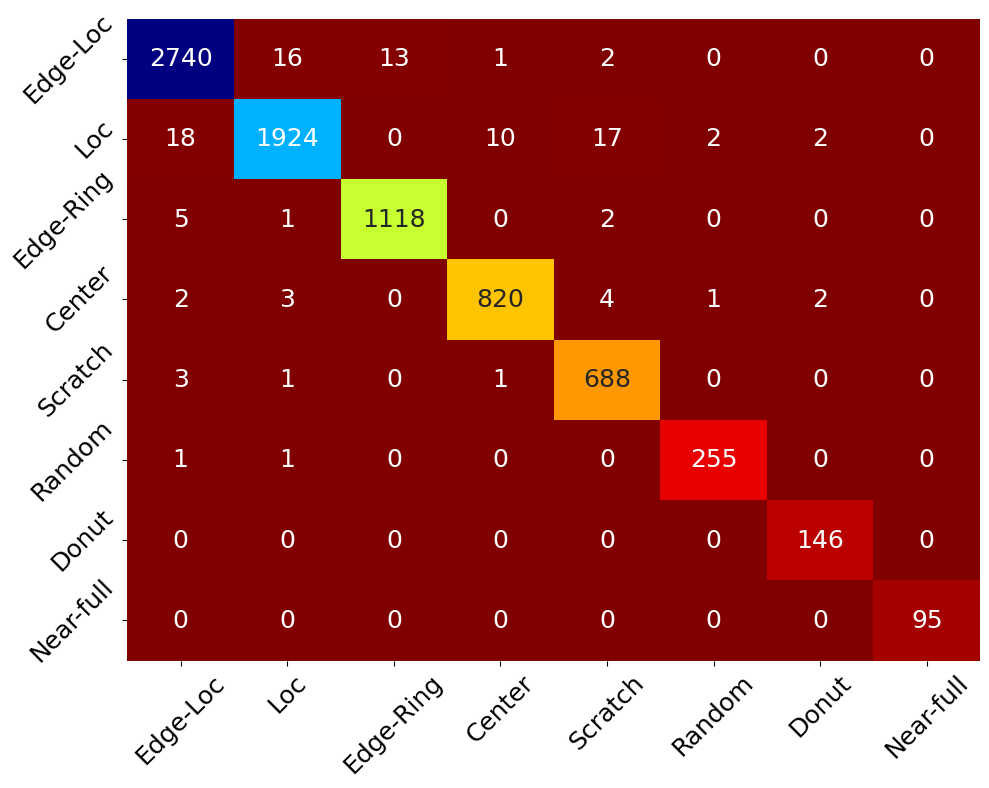

Classification Report:
              precision    recall  f1-score   support

    Edge-Loc     0.9895    0.9885    0.9890      2772
         Loc     0.9887    0.9752    0.9819      1973
   Edge-Ring     0.9885    0.9929    0.9907      1126
      Center     0.9856    0.9856    0.9856       832
     Scratch     0.9649    0.9928    0.9787       693
      Random     0.9884    0.9922    0.9903       257
       Donut     0.9733    1.0000    0.9865       146
   Near-full     1.0000    1.0000    1.0000        95

    accuracy                         0.9863      7894
   macro avg     0.9849    0.9909    0.9878      7894
weighted avg     0.9864    0.9863    0.9863      7894



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 3: Make Predictions on the predefined Test Set in the dataset
test_Y_pred = model.predict(test_X_encoded)

# Convert predictions and true labels back to class labels (from one-hot encoding)
test_Y_pred_class = np.argmax(test_Y_pred, axis=1)
test_Y_class = np.argmax(test_Y, axis=1)

# Get class names from the LabelEncoder
class_names = label_encoder.classes_

# Confusion Matrix
conf_matrix = confusion_matrix(test_Y_class, test_Y_pred_class)

# Calculate the sum of each row (true label counts)
row_sums = np.sum(conf_matrix, axis=1)

# Sort the indices based on the row sums in descending order (more frequent classes on diagonal)
sorted_indices = np.argsort(row_sums)[::-1] 

# Reorder the confusion matrix based on the sorted indices
conf_matrix_sorted = conf_matrix[sorted_indices, :][:, sorted_indices]

# Reorder class names based on the sorted indices
sorted_class_names = class_names[sorted_indices]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_sorted,
    annot=True,
    fmt='d',
    cmap='jet_r',
    xticklabels=sorted_class_names,
    yticklabels=sorted_class_names,
    cbar=False,
    annot_kws={"size": 16}
)
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=45)
plt.tight_layout()
plt.show()


# Classification Report with 4 decimal places
class_report = classification_report(
    test_Y_class, 
    test_Y_pred_class, 
    target_names=class_names, 
    digits=4 
)
print("Classification Report:")
print(class_report)


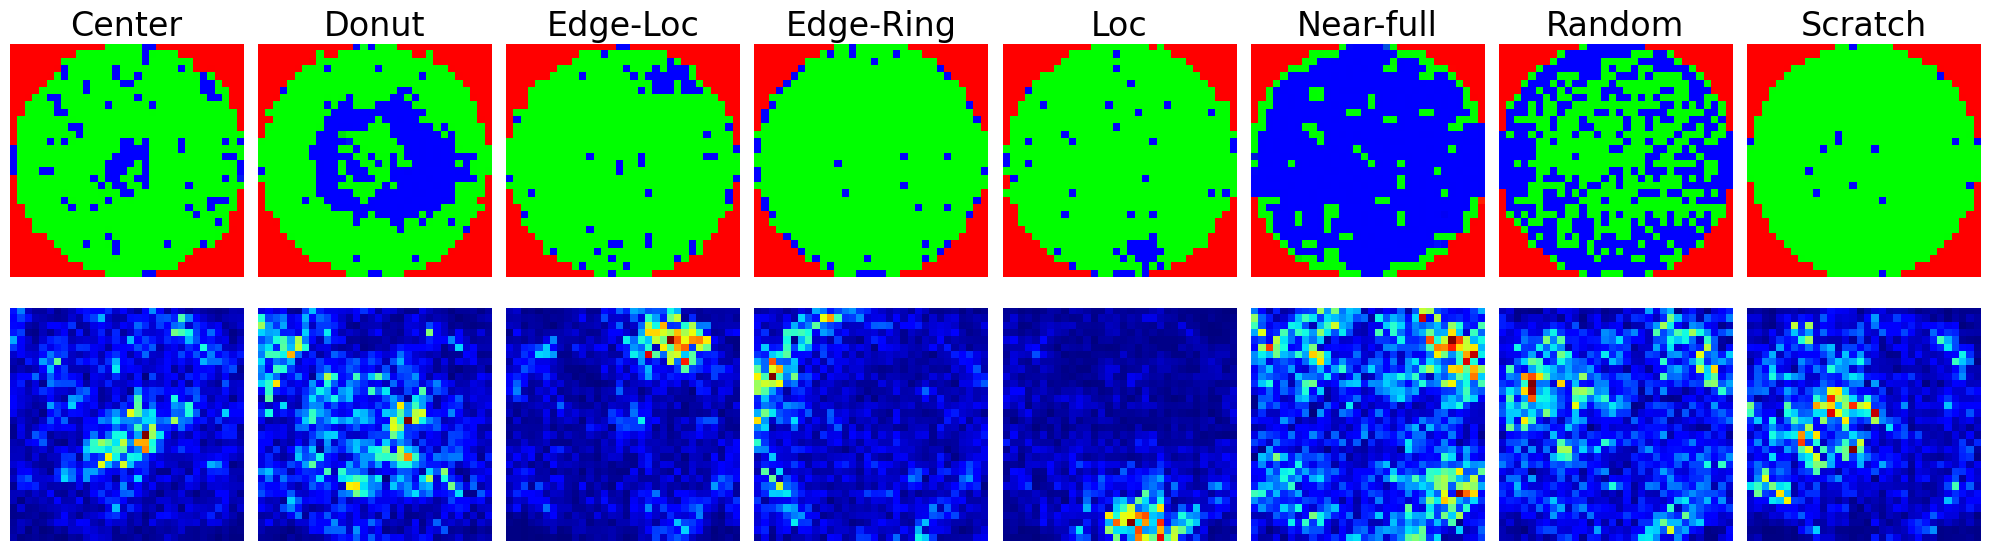

In [ ]:
# === Saliency Display Function ===
def display_saliency_with_class_names(model, images, labels, classes):
    """
    Displays original images and their corresponding saliency maps with class names.

    Args:
        model (tf.keras.Model): Trained model.
        images (np.ndarray): Array of input images.
        labels (np.ndarray): Ground truth class indices.
        classes (list): List of class names.
    """
    num_images = len(images)
    saliency_maps = []

    for i, image in enumerate(images):
        # Convert image to tensor with batch dimension
        input_image = tf.convert_to_tensor(image[np.newaxis, ...], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(input_image)
            predictions = model(input_image)
            loss = predictions[0, labels[i]]

        # Compute gradients
        gradients = tape.gradient(loss, input_image)
        saliency = tf.reduce_max(tf.abs(gradients), axis=-1).numpy()[0]
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min()) 
        saliency_maps.append(saliency)

    # Plot original images and saliency maps
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))

    for i in range(num_images):
        axes[0, i].imshow(images[i], cmap=cm)
        axes[0, i].axis('off')
        axes[0, i].set_title(classes[labels[i]], fontsize=24)

        axes[1, i].imshow(saliency_maps[i], cmap='jet')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel('Original', fontsize=24)
    axes[1, 0].set_ylabel('Saliency', fontsize=24)

    plt.tight_layout()
    plt.show()


# Class names in dataset
class_names = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']

# Ensure 1 image per class
y_labels = np.argmax(y_test, axis=1)
selected_images = []
selected_labels = []

for class_id in range(8):
    class_indices = np.where(y_labels == class_id)[0]
    if len(class_indices) > 0:
        idx = np.random.choice(class_indices) 
        selected_images.append(x_test[idx])
        selected_labels.append(class_id)

selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

# Display saliency maps
display_saliency_with_class_names(model, selected_images, selected_labels, class_names)


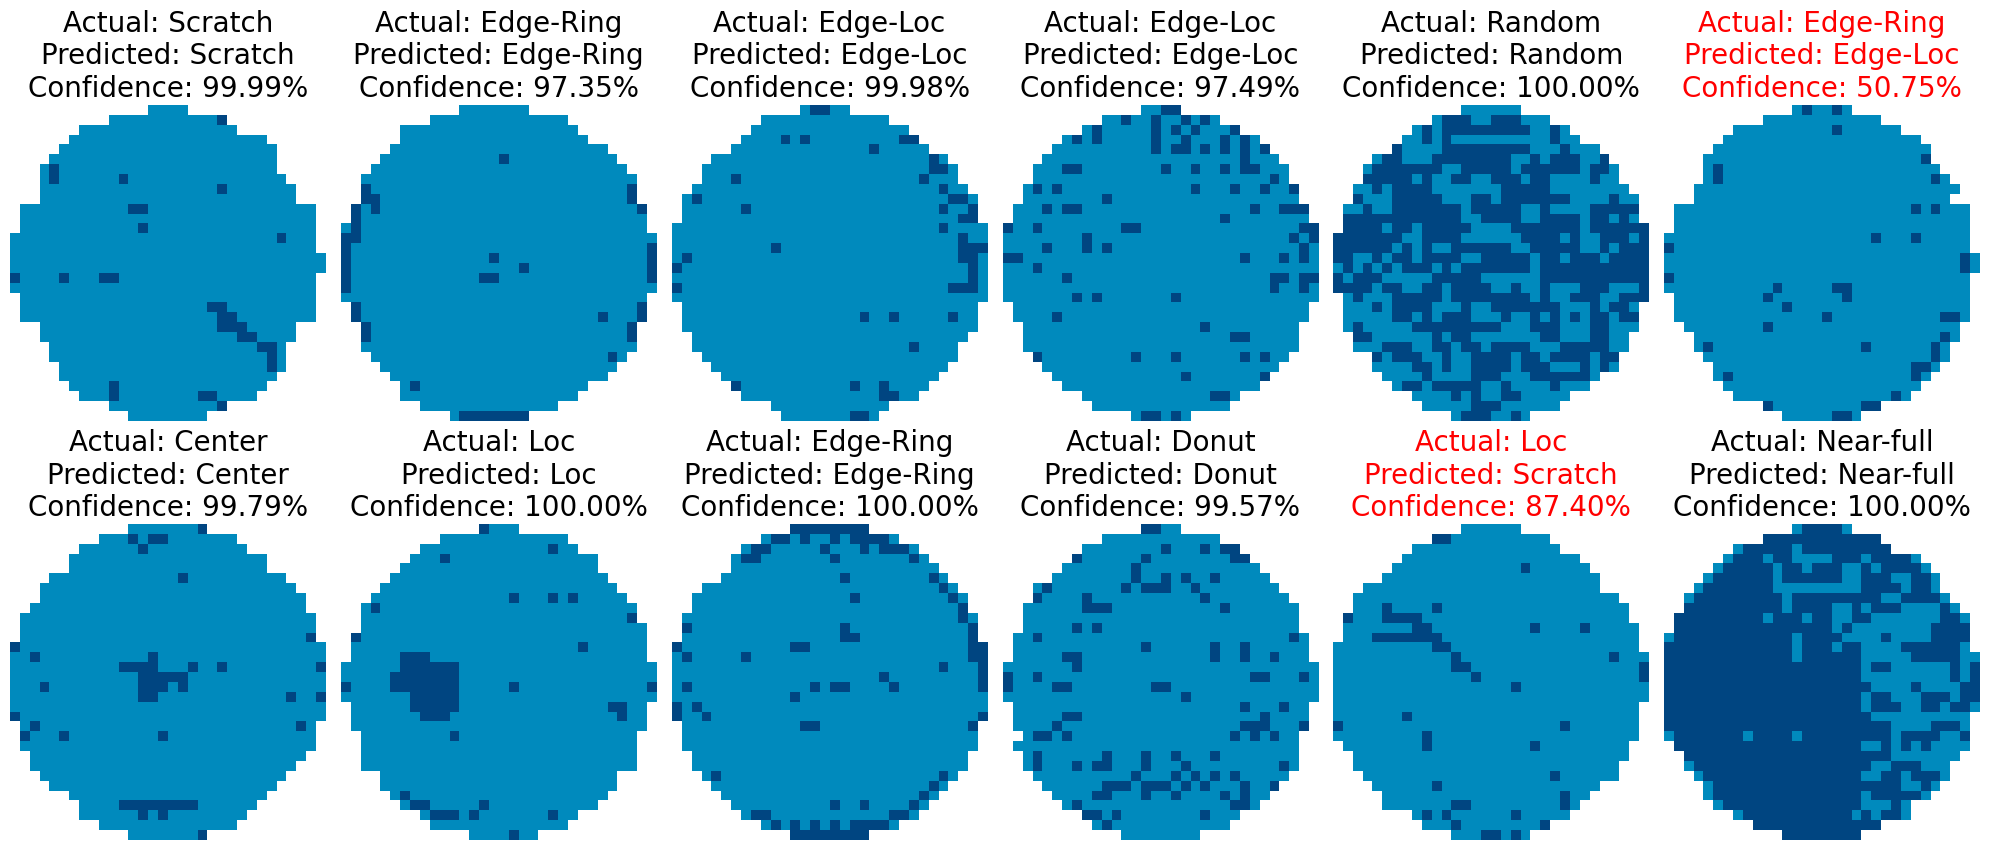

In [ ]:
# Identify misclassified and correctly classified indices grouped by class
class_indices = {i: [] for i in range(len(label_encoder.classes_))}  
for i in range(len(test_Y)):
    actual_class_index = np.argmax(test_Y[i])
    class_indices[actual_class_index].append(i)

# Select 8 different classes
selected_classes = np.random.choice(list(class_indices.keys()), size=8, replace=False)

# Select one sample per selected class
selected_indices = []
for cls in selected_classes:
    if class_indices[cls]:  
        selected_indices.append(np.random.choice(class_indices[cls]))

# Add 2 random misclassified samples if available
misclassified_indices = [
    i for i in range(len(test_Y))
    if np.argmax(test_Y[i]) != np.argmax(test_Y_pred[i])
]
if len(misclassified_indices) >= 2:
    selected_indices.extend(np.random.choice(misclassified_indices, size=2, replace=False))
else:
    selected_indices.extend(misclassified_indices)

# Ensure we have exactly 10 samples by adding randomly from the remaining correct classifications
if len(selected_indices) < 12:
    remaining_indices = [
        i for i in range(len(test_Y))
        if i not in selected_indices
    ]
    selected_indices.extend(np.random.choice(remaining_indices, size=12 - len(selected_indices), replace=False))

# Shuffle the indices to randomize positions
np.random.shuffle(selected_indices)

# Plotting
plt.figure(figsize=(20, 9))
for i, idx in enumerate(selected_indices):
    plt.subplot(2, 6, i + 1)
    
    # Extract the wafer map
    wafer_map = test_X_encoded[idx]
    
    # Determine actual and predicted classes
    actual_class_index = np.argmax(test_Y[idx])
    predicted_class_index = np.argmax(test_Y_pred[idx])
    actual_class_name = label_encoder.classes_[actual_class_index]
    predicted_class_name = label_encoder.classes_[predicted_class_index]
    
    # Extract prediction confidence
    confidence = np.max(test_Y_pred[idx])
    
    # Highlight misclassified samples
    title_color = "red" if actual_class_index != predicted_class_index else "black"
    
    # Display the wafer map
    plt.imshow(np.argmax(wafer_map, axis=-1), cmap=cm)  
    plt.title(
        f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}\nConfidence: {confidence*100:.2f}%",
        color=title_color,
        fontsize=20
    )
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Layer name: Input_Layer


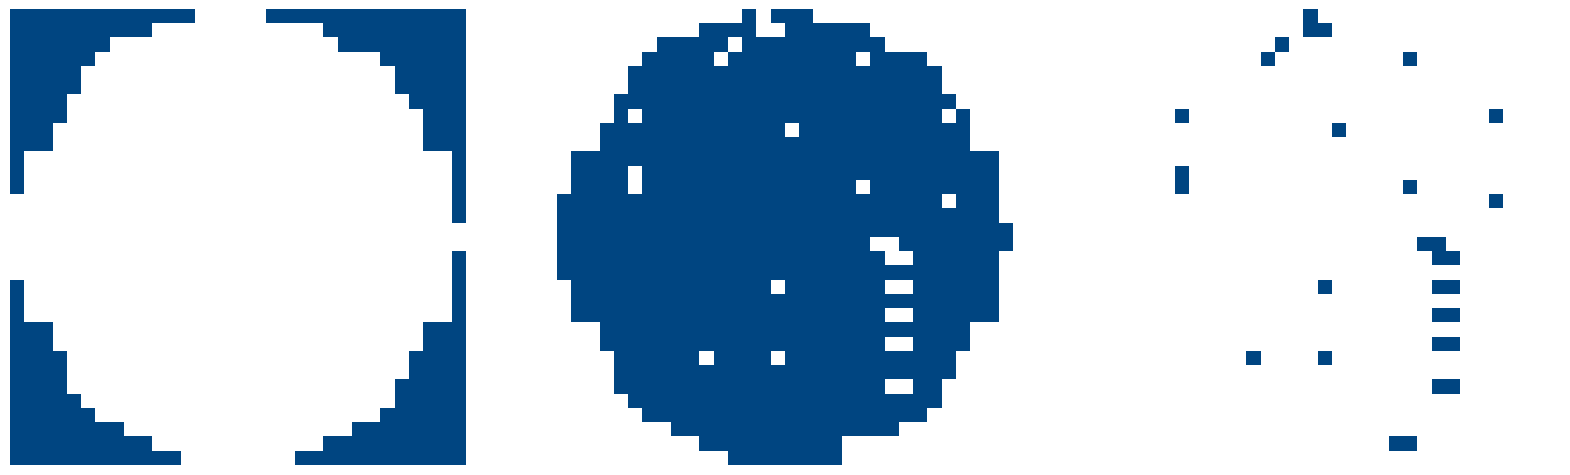

Layer name: Conv1


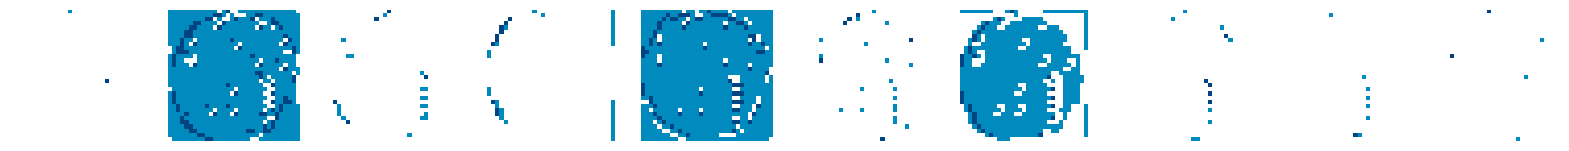

Layer name: BatchNorm1


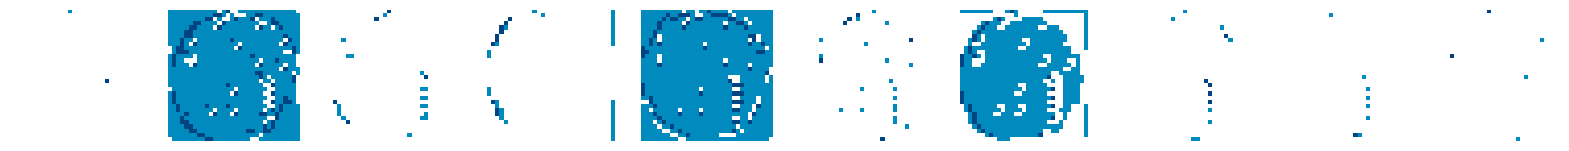

Layer name: MaxPool1


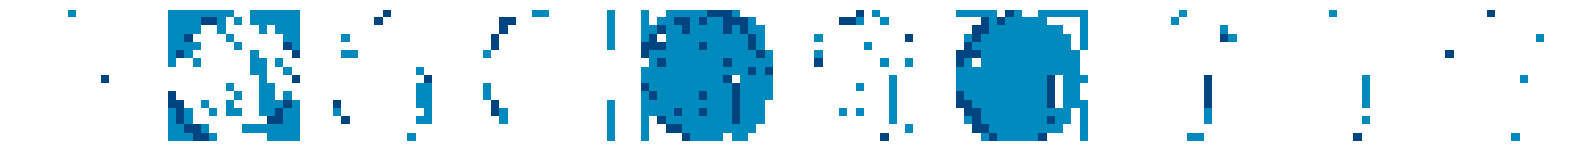

Layer name: Conv2


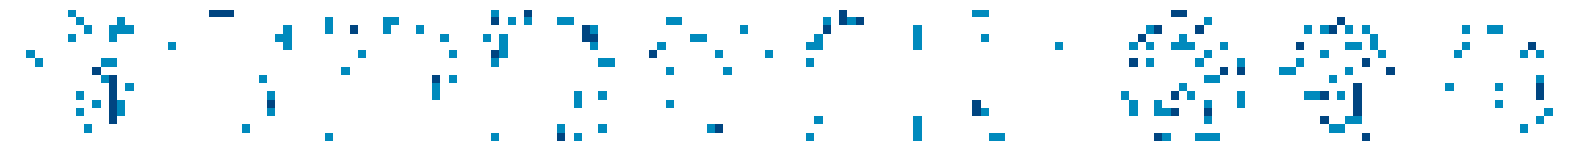

Layer name: BatchNorm2


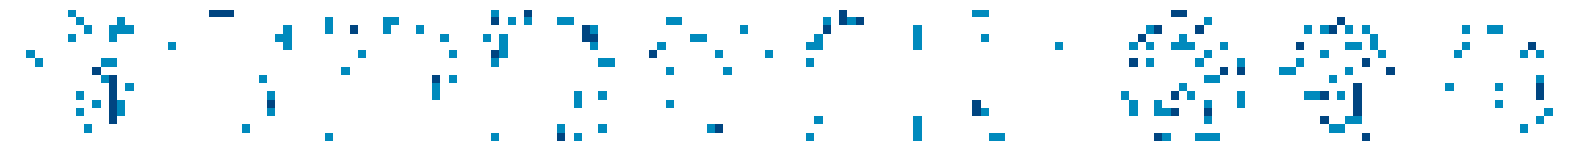

Layer name: MaxPool2


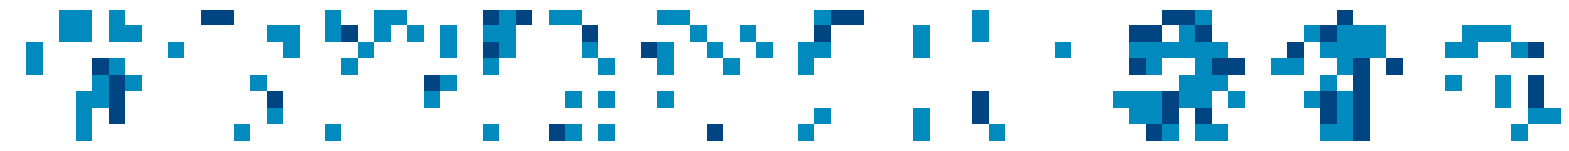

Layer name: Conv3


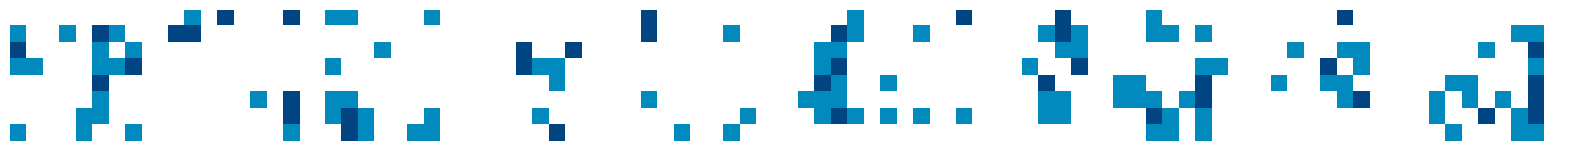

Layer name: BatchNorm3


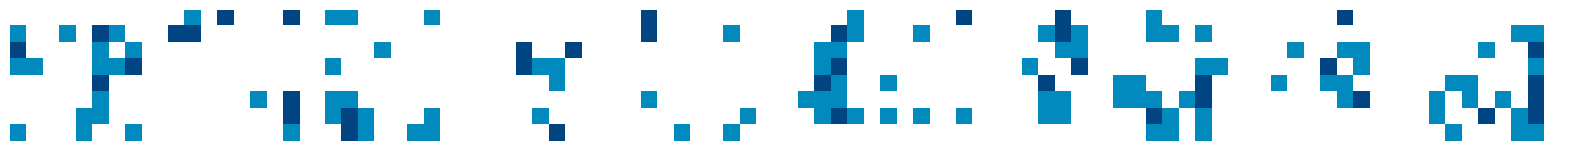

Layer name: MaxPool3


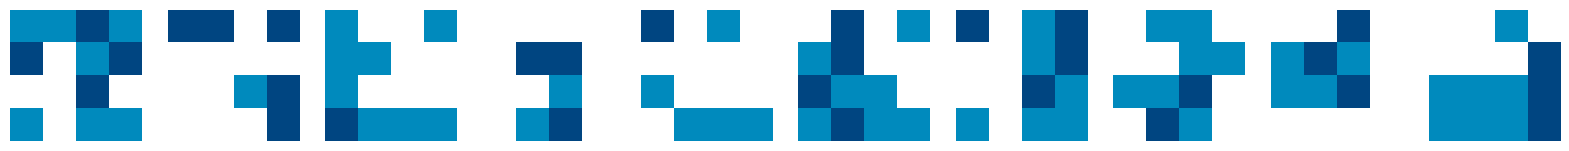

Layer name: differential_attention


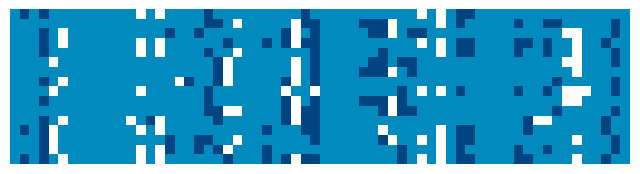

Layer name: global_average_pooling1d


Layer name: Flatten


Layer name: Dropout1


Layer name: Dense_128


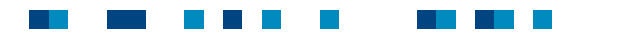

Layer name: Dropout2


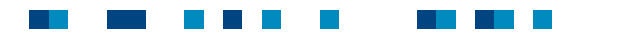

Layer name: Output_Layer


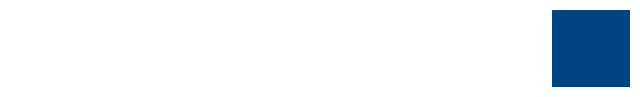

In [ ]:
# Define custom colormap using hex values
colors = ['#FFFFFF', '#018ABD', '#004581']
n_bins = 3  # Number of bins (0, 1, 2)
cmap_name = 'custom_cmap'

# Create the colormap from hex values
cm_custom = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Function to display feature maps for all layers
def visualize_feature_maps(model, input_image):
    """
    Visualize the feature maps of each layer in the model.

    Parameters:
    - model: The trained Keras model.
    - input_image: Input image to pass through the model.
    """
    # Create a model that will return the output of all layers
    layer_outputs = [layer.output for layer in model.layers]  
    feature_model = models.Model(inputs=model.input, outputs=layer_outputs)

    # Get feature maps for the input image
    feature_maps = feature_model.predict(input_image)

    # Iterate through each feature map
    for layer_name, fmap in zip([layer.name for layer in model.layers], feature_maps):
        print(f"Layer name: {layer_name}")
        
        # Handle convolutional and attention layers (4D output)
        if len(fmap.shape) == 4:  
            num_filters = fmap.shape[-1]
            num_plots = min(num_filters, 10)  

            # Plot the feature maps in 10 subplots for convolutional layers
            fig, axes = plt.subplots(1, num_plots, figsize=(20, 8))  
            for i in range(num_plots):
                ax = axes[i]
                ax.matshow(fmap[0, :, :, i], cmap=cm_custom)
                ax.axis('off')
            plt.show()

        # Handle layers with 3D output (e.g., attention layers or pooling layers)
        elif len(fmap.shape) == 3:  
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.matshow(fmap[0, :, :], cmap=cm_custom)  
            ax.axis('off')
            plt.show()
        
        # Handle 2D layers (e.g., Dense layers)
        elif len(fmap.shape) == 2: 
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.matshow(fmap[0, :].reshape(1, -1), cmap=cm_custom)  
            ax.axis('off')
            plt.show()

# Example Usage: Visualizing a real image from test data
input_image = test_X_encoded[13:14] 

# Visualize the feature maps of each layer in the model
visualize_feature_maps(model, input_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


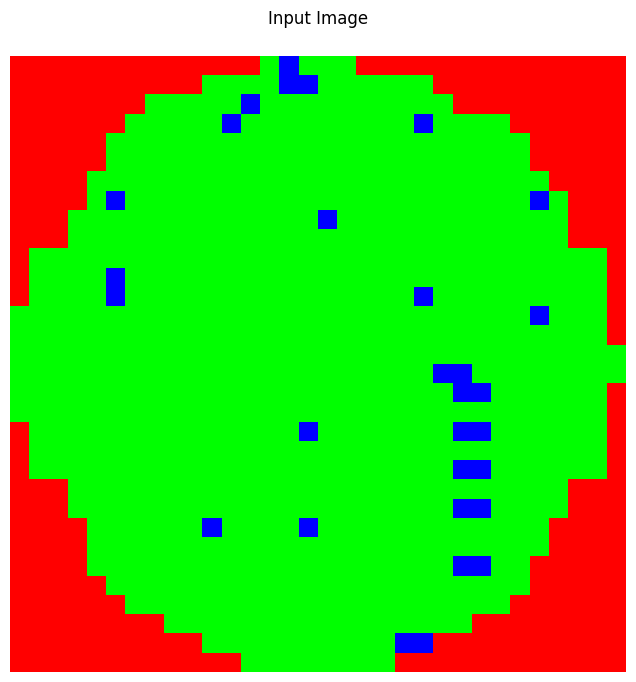

Layer name: differential_attention (Attention Layer or Pooling Layer)


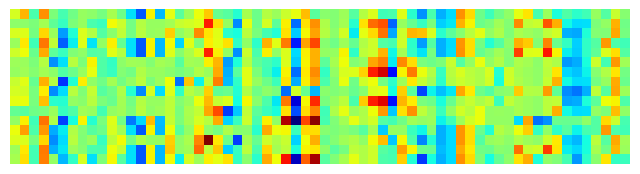

Layer name: Input_Layer


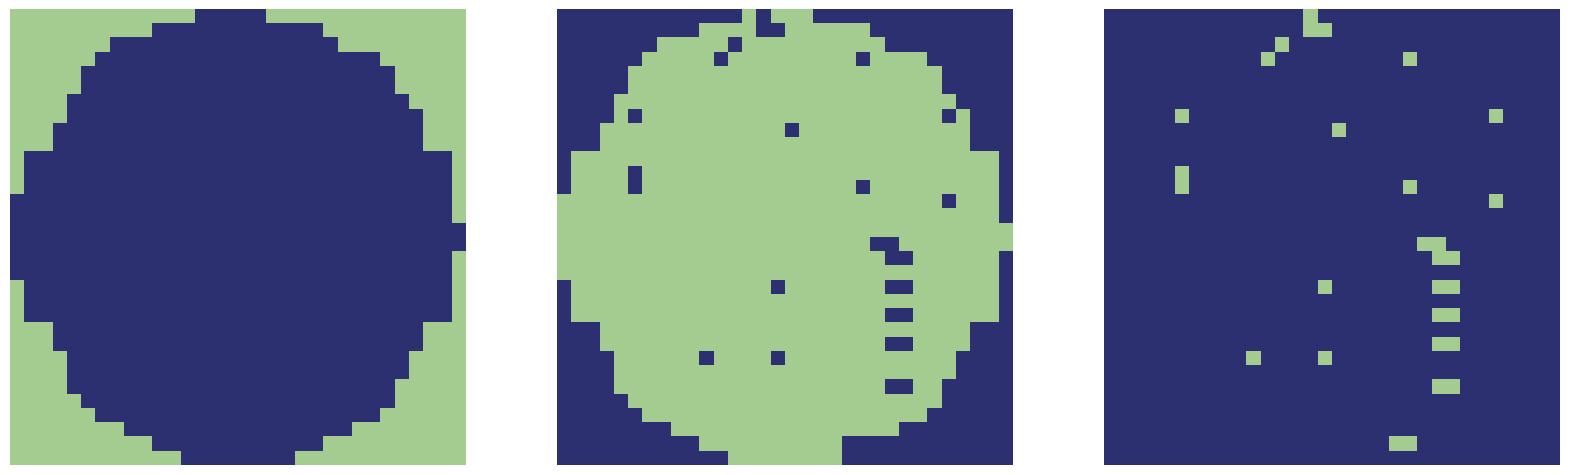

Layer name: Conv1


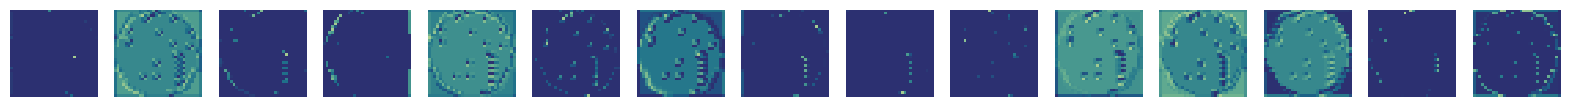

Layer name: BatchNorm1


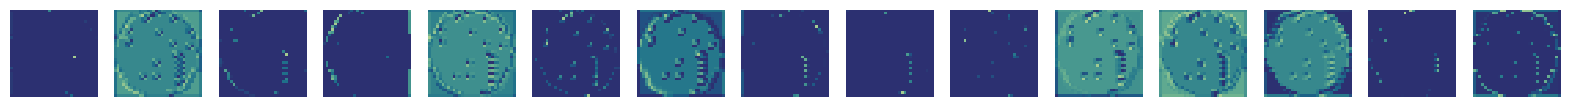

Layer name: MaxPool1


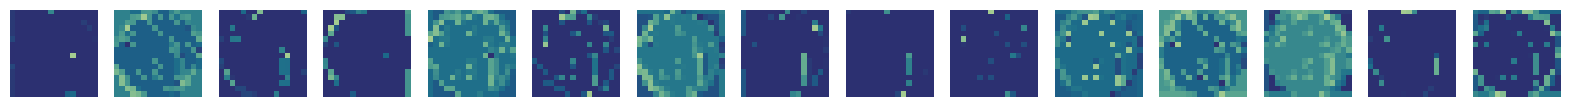

Layer name: Conv2


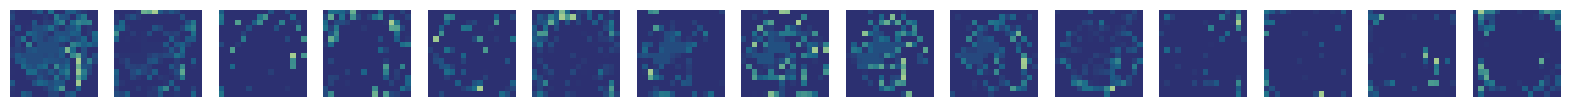

Layer name: BatchNorm2


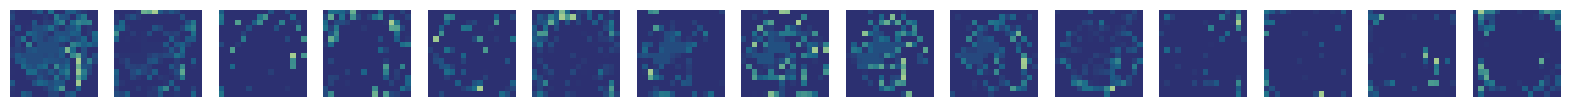

Layer name: MaxPool2


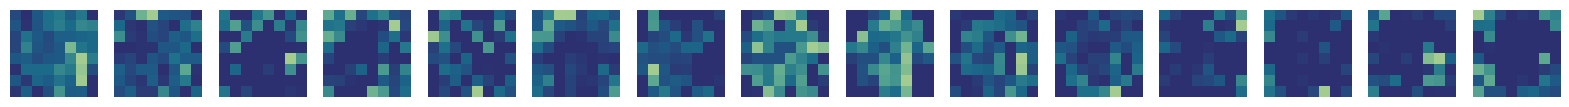

Layer name: Conv3


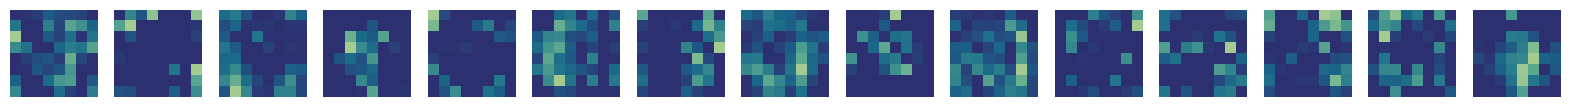

Layer name: BatchNorm3


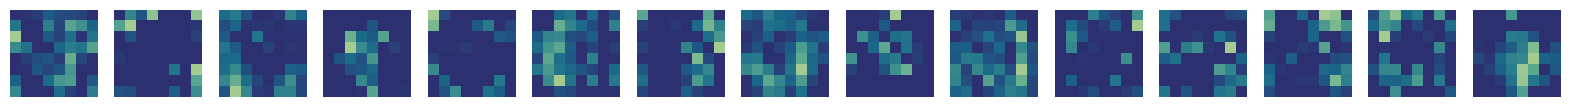

Layer name: MaxPool3


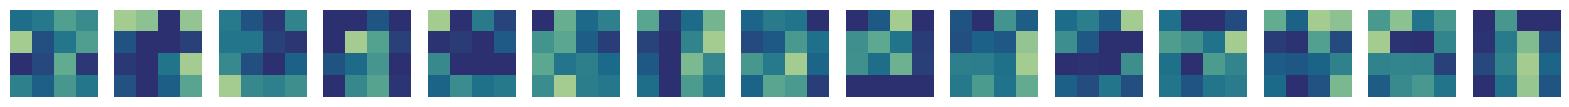

Layer name: differential_attention
Layer name: global_average_pooling1d


Layer name: Flatten


Layer name: Dropout1


Layer name: Dense_128


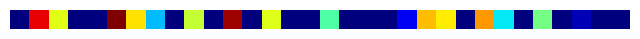

Layer name: Dropout2


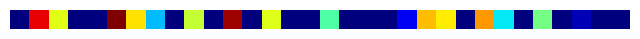

Layer name: Output_Layer


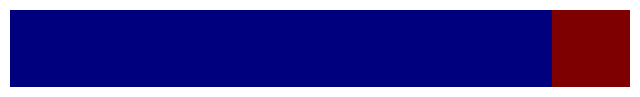

In [ ]:
# Define custom colormap using hex values
colors = ['#FFFFFF', '#018ABD', '#004581']  
n_bins = 3 
cmap_name = 'custom_cmap'

# Create the colormap from hex values
cm_custom = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Function to display feature maps for all layers
def visualize_feature_maps(model, input_image):
    """
    Visualize the feature maps of each layer in the model.

    Parameters:
    - model: The trained Keras model.
    - input_image: Input image to pass through the model.
    """
    # Create a model that will return the output of all layers
    layer_outputs = [layer.output for layer in model.layers] 
    feature_model = models.Model(inputs=model.input, outputs=layer_outputs)  

    # Get feature maps for the input image
    feature_maps = feature_model.predict(input_image)

    # Separate the input image visualization (First input image visualization)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.matshow(input_image[0], cmap=cm_custom)  
    ax.axis('off')
    plt.title("Input Image")
    plt.show()

    # Separate handling for Attention Layer (3D output) if any
    for layer_name, fmap in zip([layer.name for layer in model.layers], feature_maps):
        if len(fmap.shape) == 3: 
            print(f"Layer name: {layer_name} (Attention Layer or Pooling Layer)")
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.matshow(fmap[0, :, :], cmap='jet') 
            ax.axis('off')
            plt.show()

    # Iterate through each feature map for convolutional or dense layers
    for layer_name, fmap in zip([layer.name for layer in model.layers], feature_maps):
        print(f"Layer name: {layer_name}")
        
        # Handle convolutional layers (4D output)
        if len(fmap.shape) == 4:  
            num_filters = fmap.shape[-1]
            num_plots = min(num_filters, 15)  
            # Plot the feature maps in 10 subplots for convolutional layers
            fig, axes = plt.subplots(1, num_plots, figsize=(20, 8)) 
            for i in range(num_plots):
                ax = axes[i]
                ax.matshow(fmap[0, :, :, i], cmap='crest_r')  
                ax.axis('off')
            plt.show()

        # Handle 2D layers (e.g., Dense or Flatten layers)
        elif len(fmap.shape) == 2:  
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.matshow(fmap[0, :].reshape(1, -1), cmap='jet')  
            ax.axis('off')
            plt.show()

# Visualizing a real image from test data
input_image = test_X_encoded[13:14]

# Visualize the feature maps of each layer in the model
visualize_feature_maps(model, input_image)


In [ ]:
# Attention Layer Function
def attention_layer(input_tensor, units, name_prefix="Attention"):
    # Query, Key, and Value layers
    query = layers.Dense(units, name=f"{name_prefix}_Query_Layer")(input_tensor)
    key = layers.Dense(units, name=f"{name_prefix}_Key_Layer")(input_tensor)
    value = layers.Dense(units, name=f"{name_prefix}_Value_Layer")(input_tensor)

    # Scaled dot-product attention
    score = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1], transpose_b=True) / tf.sqrt(
            tf.cast(tf.shape(inputs[1])[-1], tf.float32)
        ),
        name=f"{name_prefix}_Scaled_Dot_Product",
    )([query, key])
    attention_weights = layers.Softmax(name=f"{name_prefix}_Weights")(score)
    attention_output = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1]),
        name=f"{name_prefix}_Output",
    )([attention_weights, value])

    # Residual connection
    output_tensor = layers.Add(name=f"{name_prefix}_Add")([input_tensor, attention_output])
    return output_tensor


# Model Definition
def create_model():
    # Input layer
    input_layer = Input(shape=(32, 32, 3), name="Input_Layer")

    # Convolutional and Pooling layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv1")(input_layer)
    x = layers.BatchNormalization(name="BatchNorm1")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool1")(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv2")(x)
    x = layers.BatchNormalization(name="BatchNorm2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool2")(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(name="BatchNorm3")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool3")(x)

    # Attention Layer
    x = attention_layer(x, units=128, name_prefix="Attention")

    # Flatten layer
    x = layers.Flatten(name="Flatten")(x)

    # Fully connected layers
    x = layers.Dropout(0.3, name="Dropout1")(x)
    x = layers.Dense(32, activation='relu', name="Dense_128")(x)
    x = layers.Dropout(0.2, name="Dropout2")(x)

    # Output layer
    output_layer = layers.Dense(8, activation='softmax', name="Output_Layer")(x)

    # Define the model
    model = models.Model(inputs=input_layer, outputs=output_layer, name="Functional_Model")
    return model


# Create and compile the model
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "Functional_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 32, 32, 32)     │            896 │ Input_Layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BatchNorm1                │ (None, 32, 32, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPool1 (MaxPooling2D)   │ (None, 16, 16, 32)     │              0 │ BatchNorm1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 16, 16, 64)     │         18,496 │ MaxPool1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BatchNorm2                │ (None, 16, 16, 64)     │            256 │ Conv2[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPool2 (MaxPooling2D)   │ (None, 8, 8, 64)       │              0 │ BatchNorm2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv3 (Conv2D)            │ (None, 8, 8, 128)      │         73,856 │ MaxPool2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ BatchNorm3                │ (None, 8, 8, 128)      │            512 │ Conv3[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MaxPool3 (MaxPooling2D)   │ (None, 4, 4, 128)      │              0 │ BatchNorm3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Query_Layer     │ (None, 4, 4, 128)      │         16,512 │ MaxPool3[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Key_Layer       │ (None, 4, 4, 128)      │         16,512 │ MaxPool3[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Scaled_Dot_Pro… │ (None, 4, 4, 4)        │              0 │ Attention_Query_Layer… │
│ (Lambda)                  │                        │                │ Attention_Key_Layer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Weights         │ (None, 4, 4, 4)        │              0 │ Attention_Scaled_Dot_… │
│ (Softmax)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Value_Layer     │ (None, 4, 4, 128)      │         16,512 │ MaxPool3[0][0]         │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Attention_Output (Lam

 Total params: 209,512 (818.41 KB)

 Trainable params: 209,064 (816.66 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    # Stop training early if validation loss stops improving
    EarlyStopping(
        monitor='val_accuracy', 
        patience=10,  
        restore_best_weights=True, 
        verbose=1
    ),
    # Save the best model based on validation loss
    ModelCheckpoint(
        filepath='/kaggle/working/best_model.keras',  
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5,  
        patience=10, 
        min_lr=1e-6,  
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,  
    batch_size=32, 
    shuffle=True,
    verbose=1,
    callbacks=callbacks 
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6769 - loss: 0.9168
Epoch 1: val_accuracy improved from -inf to 0.84192, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6770 - loss: 0.9166 - val_accuracy: 0.8419 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 2/20
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8179 - loss: 0.4747
Epoch 2: val_accuracy improved from 0.84192 to 0.86266, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8179 - loss: 0.4747 - val_accuracy: 0.8627 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 3/20
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.4045
Epoch 3: val_accuracy improved from 0.86266 to 0.87176, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8448 - loss: 0.4045 - val_accuracy: 0.8718 - val_loss: 0.3147 - learning_rate: 0

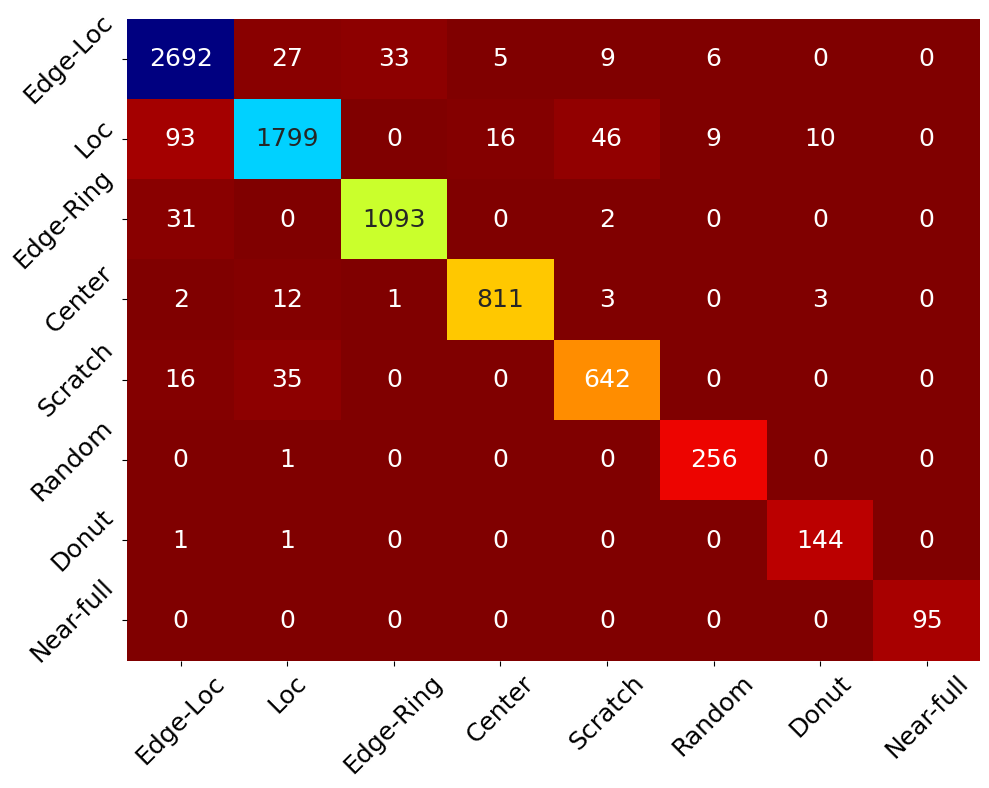

Classification Report:
              precision    recall  f1-score   support

    Edge-Loc     0.9496    0.9711    0.9602      2772
         Loc     0.9595    0.9118    0.9350      1973
   Edge-Ring     0.9698    0.9707    0.9703      1126
      Center     0.9748    0.9748    0.9748       832
     Scratch     0.9145    0.9264    0.9204       693
      Random     0.9446    0.9961    0.9697       257
       Donut     0.9172    0.9863    0.9505       146
   Near-full     1.0000    1.0000    1.0000        95

    accuracy                         0.9541      7894
   macro avg     0.9537    0.9672    0.9601      7894
weighted avg     0.9544    0.9541    0.9540      7894



In [ ]:
# Step 3: Make Predictions on the Test Set
test_Y_pred = model.predict(test_X_encoded)

# Convert predictions and true labels back to class labels (from one-hot encoding)
test_Y_pred_class = np.argmax(test_Y_pred, axis=1)
test_Y_class = np.argmax(test_Y, axis=1)

# Get class names from the LabelEncoder
class_names = label_encoder.classes_

# Confusion Matrix
conf_matrix = confusion_matrix(test_Y_class, test_Y_pred_class)

# Calculate the sum of each row (true label counts)
row_sums = np.sum(conf_matrix, axis=1)

# Sort the indices based on the row sums in descending order (more frequent classes on diagonal)
sorted_indices = np.argsort(row_sums)[::-1] 

# Reorder the confusion matrix based on the sorted indices
conf_matrix_sorted = conf_matrix[sorted_indices, :][:, sorted_indices]

# Reorder class names based on the sorted indices
sorted_class_names = class_names[sorted_indices]


plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_sorted,
    annot=True,
    fmt='d',
    cmap='jet_r',
    xticklabels=sorted_class_names,
    yticklabels=sorted_class_names,
    cbar=False,
    annot_kws={"size": 18}
)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18, rotation=45)
plt.tight_layout()
plt.show()


# Classification Report
print("Classification Report:")
print(classification_report(
    test_Y_class,
    test_Y_pred_class,
    target_names=class_names,
    digits=4
))


In [ ]:
# Input layer
input_layer = Input(shape=(32, 32, 3), name="Input_Layer")

# Convolutional and Pooling layers
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="Conv1")(input_layer)
x = layers.BatchNormalization(name="BatchNorm1")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool1")(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name="Conv2")(x)
x = layers.BatchNormalization(name="BatchNorm2")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool2")(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="Conv3")(x)
x = layers.BatchNormalization(name="BatchNorm3")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="MaxPool3")(x)

# Flatten layer
x = layers.Flatten(name="Flatten")(x)

# Fully connected layers
x = layers.Dropout(0.3, name="Dropout1")(x)
x = layers.Dense(32, activation='relu', name="Dense_128")(x)
x = layers.Dropout(0.2, name="Dropout2")(x)

# Output layer
output_layer = layers.Dense(8, activation='softmax', name="Output_Layer")(x)

# Define the model
model = models.Model(inputs=input_layer, outputs=output_layer, name="Functional_Model")

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "Functional_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm1 (BatchNormalization)      │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool1 (MaxPooling2D)              │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm2 (BatchNormalization)      │ (None, 16, 16, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool2 (MaxPooling2D)              │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm3 (BatchNormalization)      │ (None, 8, 8, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool3 (MaxPooling2D)              │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_128 (Dense)                    │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,976 (624.91 KB)

 Trainable params: 159,528 (623.16 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Define callbacks
callbacks = [
    # Stop training early if validation loss stops improving
    EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1
    ),
    # Save the best model based on validation loss
    ModelCheckpoint(
        filepath='/kaggle/working/best_model.keras',  
        monitor='val_accuracy', 
        save_best_only=True, 
        verbose=1
    ),
    # Reduce learning rate if validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6,  
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=50,  
    batch_size=32, 
    shuffle=True,
    verbose=1,
    callbacks=callbacks 
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6604 - loss: 0.9099
Epoch 1: val_accuracy improved from -inf to 0.82393, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.6605 - loss: 0.9097 - val_accuracy: 0.8239 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 2/50
1220/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8342 - loss: 0.4343
Epoch 2: val_accuracy improved from 0.82393 to 0.86123, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8342 - loss: 0.4343 - val_accuracy: 0.8612 - val_loss: 0.3668 - learning_rate: 0.0010
Epoch 3/50
1211/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8632 - loss: 0.3638
Epoch 3: val_accuracy improved from 0.86123 to 0.90098, saving model to /kaggle/working/best_model.keras
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8633 - loss: 0.3636 - val_accuracy: 0.9010 - val_loss: 0.2611 - learning_rate: 0

247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


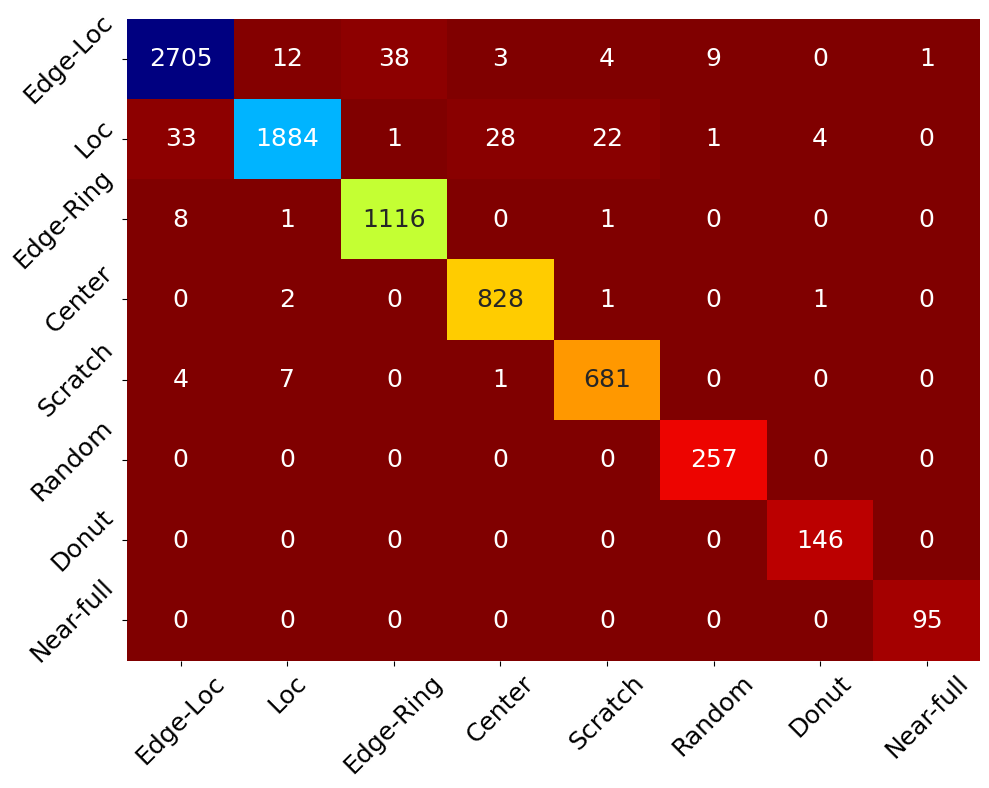

Classification Report:
              precision    recall  f1-score   support

      Center     0.9563    0.9473    0.9518      2772
       Donut     0.9629    0.9067    0.9340      1973
    Edge-Loc     0.9428    0.9813    0.9617      1126
   Edge-Ring     0.9317    0.9844    0.9573       832
         Loc     0.9085    0.9307    0.9195       693
   Near-full     0.8947    0.9922    0.9410       257
      Random     0.9595    0.9726    0.9660       146
     Scratch     0.9896    1.0000    0.9948        95

    accuracy                         0.9470      7894
   macro avg     0.9432    0.9644    0.9532      7894
weighted avg     0.9477    0.9470    0.9469      7894



In [ ]:
# Step 3: Make Predictions on the Test Set
test_Y_pred = model.predict(test_X_encoded)

# Convert predictions and true labels back to class labels (from one-hot encoding)
test_Y_pred_class = np.argmax(test_Y_pred, axis=1)
test_Y_class = np.argmax(test_Y, axis=1)

# Get class names from the LabelEncoder
class_names = label_encoder.classes_

# Confusion Matrix
conf_matrix = confusion_matrix(test_Y_class, test_Y_pred_class)

# Calculate the sum of each row (true label counts)
row_sums = np.sum(conf_matrix, axis=1)

# Sort the indices based on the row sums in descending order (more frequent classes on diagonal)
sorted_indices = np.argsort(row_sums)[::-1]  

# Reorder the confusion matrix based on the sorted indices
conf_matrix_sorted = conf_matrix[sorted_indices, :][:, sorted_indices]

# Reorder class names based on the sorted indices
sorted_class_names = class_names[sorted_indices]


plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_sorted,
    annot=True,
    fmt='d',
    cmap='jet_r',
    xticklabels=sorted_class_names,
    yticklabels=sorted_class_names,
    cbar=False,
    annot_kws={"size": 18}
)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18, rotation=45)
plt.tight_layout()
plt.show()


# Classification Report
print("Classification Report:")
print(classification_report(
    test_Y_class,
    test_Y_pred_class,
    target_names=class_names,
    digits=4
))
